# Sentiment Analysis Comment Instagram CyberBullying

Nama : Nadea Putri Nur Fauzi

Kelas : Ular

Program : AI Mastery Batch 3

## Step 1 (Import Library)

In [ ]:
!pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.1 MB/s 


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
import nltk 
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 2 (Data Acquisition)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_komentar_instagram_cyberbullying.csv')
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


Melihat label unik pada sentiment

In [ ]:
data['Sentiment'].unique()

array(['negative', 'positive'], dtype=object)

Melihat jumlah masing-masing label yang unik

In [ ]:
print('Total Jumlah Sentiment:', data.shape[0], 'data\n')
print('Label data terdiri dari:')
print('>> [0] Positive\t:', data[data.Sentiment == 'negative'].shape[0], 'data')
print('>> [1] Negative\t:', data[data.Sentiment == 'positive'].shape[0], 'data')

Total Jumlah Sentiment: 400 data

Label data terdiri dari:
>> [0] Positive	: 200 data
>> [1] Negative	: 200 data


Visualisasi label unik

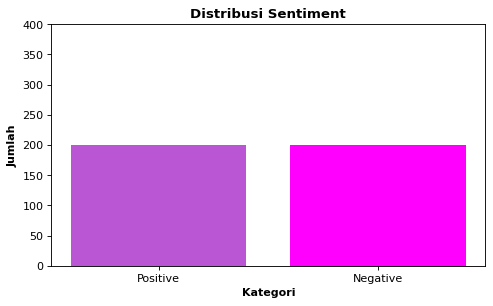

In [ ]:
height = data['Sentiment'].value_counts()
labels = ('Positive','Negative')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,400)
plt.title('Distribusi Sentiment', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['mediumorchid','magenta'])
plt.xticks(y_pos,labels)
plt.show()

Label encoder buat kolom sentiment

In [ ]:
from sklearn.preprocessing import LabelEncoder
data['Sentiment'] = LabelEncoder().fit_transform(data['Sentiment'])
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


Setelah dilakukan LabelEncoder maka untuk sentimentnya berganti menjadi angka yaitu:

Negative = 0

Postive = 1

## Step 3 (Text Preprocessing)

Casefolding

In [ ]:
def cf(text):
  text = text.lower()
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'[-+]?[0-9]+', '', text)
  text = re.sub(r'[^\w\s_]', '', text)
  text = text.strip()
  return text

In [ ]:
rawSample = data['Instagram Comment Text'].iloc[10]
caseFolding = cf(rawSample)

print('Raw Data\t:', rawSample)
print('Case Folding\t:', caseFolding)

Raw Data	: Syarat sah nikah menurut agama islam hanya 5 yaitu : adanya CPP, adanya CPW, saksi, wali nikah dan mas kawin/mahar. Perkara makeup gak manglingi bukan syarat sah pernikahan. Sekalipun gak makeup tapi syarat yg 5 tersebut terpenuhi maka pernikahannya SAH yak emak emak julids
Case Folding	: syarat sah nikah menurut agama islam hanya  yaitu  adanya cpp adanya cpw saksi wali nikah dan mas kawinmahar perkara makeup gak manglingi bukan syarat sah pernikahan sekalipun gak makeup tapi syarat yg  tersebut terpenuhi maka pernikahannya sah yak emak emak julids


Setelah dilakukan casefolding, maka untuk url, angka, dan seluruh tanda baca sudah terhapus. Huruf yang awalnya kapital/besar juga sudah menjadi kecil.

Slang Word Normalization

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-10-05 12:53:57--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>]  79.07K  --.-KB/s    in 0.01s   

2022-10-05 12:53:57 (6.26 MB/s) - ‘key_norm.csv’ saved [80969/80969]



In [ ]:
key = pd.read_csv('key_norm.csv')
print(key.head())

key.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [ ]:
def text_normalize(text):
  text = ' '.join([key[key['singkat'] == word]['hasil'].values[0] if (key['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

Setelah dilakukan normalization maka kata-kata tidak baku akan diubah ke bentuk baku

Filtering (Stopword Removal)

In [ ]:
stopwords_ind = stopwords.words('indonesian')

len(stopwords_ind)

758

Kata-kata yang dipakai hanya yang berbahasa indonesia, untuk kata inggris maka diubah ke indonesia

In [ ]:
stopwords_ind[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

Dilakukan penghapusan kata-kata inputan yang tidak ada di kamus kata, namun dirasa akan mengganggu pemodelan data

In [ ]:
more_stopword = ['kayagni','yh','yoo','mince','hadeww']

stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return ' '.join(clean_words)

In [ ]:
raw_sample = data['Instagram Comment Text'].iloc[5]
case_folding = cf(raw_sample)
normalization = text_normalize(case_folding)
stopword_removal = remove_stop_words(normalization)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Normalization\t\t: ', normalization )
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Pantesan di tinggalin laki, ya lakinya juga mikir kali kalau perempuannya kayagni. Ngurus diri aja dia gak becus gimana ngurus anak, mending anak sama bapake nya aja bener didiknya
Case folding		:  pantesan di tinggalin laki ya lakinya juga mikir kali kalau perempuannya kayagni ngurus diri aja dia gak becus gimana ngurus anak mending anak sama bapake nya aja bener didiknya
Normalization		:  pantesan di tinggalin laki ya lakinya juga berfikir kali kalau perempuannya kayagni ngurus diri saja dia tidak becus bagaimana ngurus anak mending anak sama bapake nya saja bener didiknya
Stopword removal	:  pantesan tinggalin laki ya lakinya berfikir kali perempuannya ngurus becus ngurus anak mending anak bapake nya bener didiknya


Stemming

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample = data['Instagram Comment Text'].iloc[5]
case_folding = cf(raw_sample)
normalization = text_normalize(case_folding)
stopword_removal = remove_stop_words(normalization)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Normalization\t\t: ', normalization)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Pantesan di tinggalin laki, ya lakinya juga mikir kali kalau perempuannya kayagni. Ngurus diri aja dia gak becus gimana ngurus anak, mending anak sama bapake nya aja bener didiknya
Case folding		:  pantesan di tinggalin laki ya lakinya juga mikir kali kalau perempuannya kayagni ngurus diri aja dia gak becus gimana ngurus anak mending anak sama bapake nya aja bener didiknya
Normalization		:  pantesan di tinggalin laki ya lakinya juga berfikir kali kalau perempuannya kayagni ngurus diri saja dia tidak becus bagaimana ngurus anak mending anak sama bapake nya saja bener didiknya
Stopword removal	:  pantesan tinggalin laki ya lakinya berfikir kali perempuannya ngurus becus ngurus anak mending anak bapake nya bener didiknya
Stemming		:  pantesan tinggalin laki ya laki berfikir kali perempuan ngurus becus ngurus anak mending anak bapake nya bener didik


Setelah dilakukan stemming, maka kata akan berubah ke bentuk dasarnya.

## Step 4 (Text Preprocessing Pipeline)

Membuat fungsi untuk menggabungkan seluruh proses pada preprocessing sebelum menuju pemodelan

In [ ]:
def text_preprocessing_process(text):
  text = cf(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
data['clean_teks'] = data['Instagram Comment Text'].apply(text_preprocessing_process)

CPU times: user 3min 57s, sys: 814 ms, total: 3min 58s
Wall time: 4min 6s


In [ ]:
data

,Id,Sentiment,Instagram Comment Text,clean_teks
0,1,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,username tolol hubung nya gugur pakai hijab sy...
1,2,0,Geblek lo tata...cowo bgt dibela2in balikan......,bodoh tatacowo banget bain balikanhadewwntar t...
2,3,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin mewek skr lengket duhhh labil banget s...
3,4,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",inti kesel att nya anak kasihan kembang psikis...
4,5,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan lgsakit jiwaknp peran utama...
...,...,...,...,...
395,396,1,Bangga sama suami yg selalu ingat istri disela...,bangga suami istri sela apa profesi kau juara ...
396,397,1,Apaoun pekerjaannya yg penting halal u tuk men...,apaoun kerja halal tuk nafkah keluarga semangat
397,398,1,Gojek itu mayoritas pegangguran yang lama gak ...,gojek mayoritas pegangguran kerja putus asaa t...
398,399,1,<USERNAME> aslinya cantik dan ayu loh mbak kr...,username asli cantik ayu loh mbak temu langsun...


Dari tabel ini, bisa dilihat perbedaan data yang masih mentah dan yang selesai dilakukan preprocessing

In [ ]:
data.to_csv('databaru.csv')

## Step 5 (Feature Engineering)

In [ ]:
x = data['clean_teks']
y = data['Sentiment']

## Step 6 (Feature Extraction using TF-IDF) 

Menggunakan TF-IDF untuk menyempurnakan BOW dengan perhitungan yang lebih rinci

In [ ]:
tf_idf = TfidfVectorizer(max_features=3000,ngram_range=(1,1))
tf_idf.fit(x)

TfidfVectorizer(max_features=3000)

In [ ]:
print(len(tf_idf.get_feature_names_out()))

2313


In [ ]:
print(tf_idf.get_feature_names_out())

['aamiin' 'aammiinnn' 'abal' ... 'zholimi' 'zina' 'zzzzz']


In [ ]:
x_tf_idf = tf_idf.transform(x).toarray()
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
data_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aamiin,aammiinnn,abal,abang,abbey,abege,abiiis,abiss,abu,ac,...,yesssssss,ygblaingw,youtube,yra,yuk,yutub,zaman,zholimi,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.237377,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 7 (Feature Selection)

Disini feature selection menggunakan chi2 Kbest features

In [ ]:
x = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
chi2_features = SelectKBest(chi2, k=1000) 
x_kbest_features = chi2_features.fit_transform(x, y) 

print('Original feature number:', x.shape[1]) 
print('Reduced feature number:', x_kbest_features.shape[1]) 

Original feature number: 2313
Reduced feature number: 1000


In [ ]:
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.712649,aamiin
1,0.266905,aammiinnn
2,1.016960,abal
3,0.001270,abang
4,0.488178,abbey
...,...,...
2308,0.214816,yutub
2309,0.184216,zaman
2310,0.226724,zholimi
2311,0.331307,zina


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
443,7.458519,cantik
1386,5.483230,moga
375,5.267446,bodoh
1085,4.272573,keren
1015,4.271560,kampung
...,...,...
2291,0.000043,yaelah
1777,0.000028,publik
1492,0.000026,ngefans
1849,0.000009,sakit


In [ ]:
mask = chi2_features.get_support()
mask

array([ True, False,  True, ..., False,  True,  True])

In [ ]:
# Fitur terpilih
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'abal',
 'abbey',
 'abiiis',
 'acha',
 'adat',
 'admin',
 'agus',
 'ah',
 'aja',
 'ajaaa',
 'akhlak',
 'akun',
 'akuuu',
 'alah',
 'alami',
 'alay',
 'alesha',
 'alhamdulillah',
 'alim',
 'allah',
 'allahaamiin',
 'am',
 'amanda',
 'amiiii',
 'amiiin',
 'amiin',
 'amin',
 'amit',
 'amora',
 'ampuuunmalu',
 'an',
 'anakanaknya',
 'anang',
 'anda',
 'andah',
 'anehkyknya',
 'angguunn',
 'ani',
 'anjing',
 'anjir',
 'anjirrrr',
 'antem',
 'anti',
 'anyiennnnggg',
 'apa',
 'apain',
 'apaoun',
 'api',
 'apik',
 'aplg',
 'ariel',
 'artika',
 'artis',
 'ashanti',
 'asik',
 'aslikereennn',
 'asyik',
 'ato',
 'att',
 'audisi',
 'aura',
 'aurel',
 'aw',
 'awat',
 'awet',
 'ayah',
 'ayu',
 'ayuneemana',
 'ayuuterlihat',
 'az',
 'azriel',
 'babang',
 'babi',
 'babiii',
 'baca',
 'bacot',
 'badaaiik',
 'baguass',
 'bagus',
 'bagusss',
 'bagussss',
 'bahagia',
 'baik',
 'bak',
 'bakat',
 'bala',
 'balajaer',
 'balas',
 'balikanhadewwntar',
 'banci',
 'bang',
 'bangeeet',
 'bangeg',
 'ban

In [ ]:
kbest_feature = {} 

for (k,v) in tf_idf.vocabulary_.items():    
  if k in selected_feature:                
    kbest_feature[k] = v                    

In [ ]:
kbest_feature

{'username': 2215,
 'tolol': 2150,
 'nya': 1557,
 'pakai': 1621,
 'hijab': 838,
 'panas': 1628,
 'otak': 1611,
 'sih': 1975,
 'ya': 2283,
 'komentar': 1128,
 'bodoh': 375,
 'tatacowo': 2092,
 'banget': 217,
 'balikanhadewwntar': 207,
 'nyalahin': 1565,
 'tuh': 2163,
 'cowopadahal': 498,
 'kitenya': 1108,
 'oon': 1596,
 'mbak': 1320,
 'ato': 149,
 'sensasi': 1932,
 'biar': 335,
 'att': 150,
 'kasihan': 1024,
 'orang': 1603,
 'bener': 300,
 'anda': 86,
 'benci': 298,
 'tau': 2093,
 'nama': 1452,
 'manusia': 1289,
 'suka': 2045,
 'haters': 815,
 'permpuan': 1691,
 'artis': 131,
 'pantesan': 1635,
 'tinggalin': 2142,
 'laki': 1170,
 'berfikir': 305,
 'perempuan': 1683,
 'ngurus': 1518,
 'becus': 269,
 'mending': 1333,
 'biasa': 339,
 'balajaer': 203,
 'nyampah': 1569,
 'ig': 867,
 'asik': 140,
 'lagu': 1166,
 'laknat': 1174,
 'goda': 751,
 'laku': 1175,
 'bela': 286,
 'jiwa': 973,
 'indonesia': 883,
 'buruk': 426,
 'pilih': 1713,
 'kelas': 1052,
 'ayu': 167,
 'janda': 940,
 'anyiennnnggg':

In [ ]:
data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abal,abbey,abiiis,acha,adat,admin,agus,ah,aja,...,yah,yatuhan,yeee,yeskirain,yesss,yesssssss,youtube,yra,zina,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
    pickle.dump(kbest_feature, output)

## Step 8 (Modelling using Machine Learning)

In [ ]:
from sklearn.model_selection import train_test_split    
from joblib import dump                                

Split dataset training dan testing dengan ukuran 80:20

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_kbest_features, y, test_size=0.2, random_state=42)

In [ ]:
print('Data Training = ', len(x_kbest_features))
print('Data Testing = ', len(x_test))

Data Training =  400
Data Testing =  80


## Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

Model 1 (Naive Bayes Classifier)

In [ ]:
bern = BernoulliNB()
modelbern = bern.fit(x_train,y_train)

dump(modelbern, filename='modelbern.joblib')

['modelbern.joblib']

Model 2 (Random Forest Classifier)

In [ ]:
Rforest = RandomForestClassifier(random_state=123)
modelRforest = Rforest.fit(x_train,y_train)

dump(modelRforest, filename='modelRforest.joblib')

['modelRforest.joblib']

In [ ]:
modelbern_pred = modelbern.predict(x_test)
modelbern.predict

<bound method _BaseNB.predict of BernoulliNB()>

In [ ]:
modelRforest_pred = modelRforest.predict(x_test)
modelRforest.predict

<bound method ForestClassifier.predict of RandomForestClassifier(random_state=123)>

## Model Evaluation

Model 1 (naive Bayes)

In [ ]:
prediksi_benar = (modelbern_pred == y_test).sum()
prediksi_salah = (modelbern_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 76
Jumlah prediksi salah	: 4
Akurasi pengujian	: 95.0 %


In [ ]:
print('Classification report:\n', classification_report(y_test, modelbern_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.90      1.00      0.95        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.96      0.95      0.95        80



In [ ]:
from sklearn.model_selection import ShuffleSplit    
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(modelbern, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.8875 0.9375 0.9125 0.95   0.9    0.925  0.9    0.9    0.925  0.9625] 

Rata-rata akurasi pada cross validation: 0.9200000000000002


Model 2 (Random forest)

In [ ]:
prediksi_benar = (modelRforest_pred == y_test).sum()
prediksi_salah = (modelRforest_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 69
Jumlah prediksi salah	: 11
Akurasi pengujian	: 86.25 %


In [ ]:
print('Classification report:\n', classification_report(y_test, modelRforest_pred))

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        44
           1       0.77      1.00      0.87        36

    accuracy                           0.86        80
   macro avg       0.88      0.88      0.86        80
weighted avg       0.89      0.86      0.86        80



In [ ]:
from sklearn.model_selection import ShuffleSplit   
from sklearn.model_selection import cross_val_score 

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(modelRforest, x_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.825  0.9    0.775  0.75   0.8125 0.8125 0.85   0.8125 0.8    0.8875] 

Rata-rata akurasi pada cross validation: 0.8225


## Deployment

In [ ]:
from joblib import load

# load model
model = load('modelbern.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

Contoh : gila kok ada orang seperti ini ya, sumpa benci banget

In [ ]:
input_text = input("Input a Comment: ")

pre_input_text = text_preprocessing_process(input_text)
tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))      
result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  

print('\nHasil Text Preprocessing :', pre_input_text)

if (result==0):
  sentiment = 'Comment Negative'
else:
  sentiment = 'Comment Positive'

print('\nHasil prediksi: ', input_text, ' adalah ', sentiment)

Input a Comment: gila kok ada orang seperti ini ya, sumpa benci banget

Hasil Text Preprocessing : gila orang ya sumpa benci banget

Hasil prediksi:  gila kok ada orang seperti ini ya, sumpa benci banget  adalah  Comment Negative


Kesimpulan: 

Perbandingan antara 2 model yaitu (Naive Bayes dan Random forest), akurasi terbaik yaitu model naibe bayes dengan akurasi 95%

 https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv